In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import scipy as sp
import scipy.sparse as sps
from scipy.sparse import coo_matrix
import os
import matplotlib.pyplot as pyplot
%matplotlib inline 


## Evaluation or scoring?
eval = True

In [3]:
from RecLib.DataLoad import *
# Loading from CSV files...
UCM_age = toCoo('data_UCM_age.csv', 'user', 'age')
ICM_subclass = toCoo('data_ICM_sub_class.csv', 'item', 'subclass')
ICM_asset = toCoo('data_ICM_asset.csv', 'item', 'asset')
ICM_price = toCoo('data_ICM_price.csv', 'item', 'price')
UCM_region = toCoo('data_UCM_region.csv', 'user', 'region')
target_users = toNPArray('data_target_users_test.csv')
URM = toCoo('data_train.csv', 'user', 'item')

data_UCM_age.csv
user data, ID: min 2, max 30909, length 30317, unique 30317, repetitions 0, missig 1.91 %
age data, ID: min 1, max 10, length 30317, unique 10, repetitions 30307, missig 0.00 %

data_ICM_sub_class.csv
item data, ID: min 0, max 18494, length 18495, unique 18495, repetitions 0, missig 0.00 %
subclass data, ID: min 1, max 2010, length 18495, unique 1905, repetitions 16590, missig 5.18 %

data_ICM_asset.csv
item data, ID: min 0, max 18494, length 18490, unique 18490, repetitions 0, missig 0.02 %
asset data, ID: min 0, max 0, length 18490, unique 1, repetitions 18489, missig 0.00 %

data_ICM_price.csv
item data, ID: min 0, max 18494, length 18493, unique 18493, repetitions 0, missig 0.01 %
price data, ID: min 0, max 0, length 18493, unique 1, repetitions 18492, missig 0.00 %

data_UCM_region.csv
user data, ID: min 0, max 30910, length 26609, unique 26375, repetitions 234, missig 14.67 %
region data, ID: min 0, max 7, length 26609, unique 7, repetitions 26602, missig 0.00 %


In [4]:
URM = URM.tocsr()

In [5]:
## Split dataset (train % of .9999 gives similar performance on test set and competition set)
from Notebooks_utils.data_splitter import train_test_holdout
URM_train, URM_test = train_test_holdout(URM, train_perc = 0.8)


if not eval:
    URM_train = URM
else:
    from Base.Evaluation.Evaluator import EvaluatorHoldout
    evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [5]:
## SLIM BPR Recommender - MAP 0.41 on test set
## set True if you want to train and compile SLIM BPR Recommender
if True:
    from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython 
    slim_rec = SLIM_BPR_Cython(URM_train, recompile_cython=False, verbose = False)
    MAP_LIST = []
    epochsList = [300]
    batchSize = [50]
    tklist = [10]
    lrs = [1e-3]

    for epochsN in epochsList:
        for bs in batchSize:
            for tk in tklist:
                for lr in lrs:
                    do_not_display_hystory = slim_rec.fit(epochs=epochsN, batch_size=bs, sgd_mode='adagrad', learning_rate=lr, topK = tk)
                    if eval:
                        dict_scores = (evaluator_validation.evaluateRecommender(slim_rec))[0][10]
                        MAP_LIST.append(('epoch, batch, topK, lr :' + str(epochsN) + ' ' + str(bs)+ ' ' + str(tk) + ' ' + str(lr), dict_scores['MAP']))
    if eval:
        print(MAP_LIST)

Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Epoch 1 of 300. Elapsed time 0.07 sec
SLIM_BPR_Recommender: Epoch 2 of 300. Elapsed time 0.21 sec
SLIM_BPR_Recommender: Epoch 3 of 300. Elapsed time 0.33 sec
SLIM_BPR_Recommender: Epoch 4 of 300. Elapsed time 0.62 sec
SLIM_BPR_Recommender: Epoch 5 of 300. Elapsed time 0.76 sec
SLIM_BPR_Recommender: Epoch 6 of 300. Elapsed time 0.87 sec
SLIM_BPR_Recommender: Epoch 7 of 300. Elapsed time 1.15 sec
SLIM_BPR_Recommender: Epoch 8 of 300. Elapsed time 1.28 sec
SLIM_BPR_Recommender: Epoch 9 of 300. Elapsed time 1.39 sec
SLIM_BPR_Recommender: Epoch 10 of 300. Elapsed time 1.76 sec
SLIM_BPR_Recommender: Epoch 11 of 300. Elapsed time 1.87 sec
SLIM_BPR_Recommender: Epoch 12 of 300. Elapsed time 1.99 sec
SLIM_BPR_Recommender: Epoch 13 of 300. Elapsed time 2.38 sec
SLIM_BPR_Recommender: Epoch 14 of 300. Elapsed time 2.51 sec
SLIM_BPR_Recommender: Epoch 15 of 300. Elapsed time 2.62 sec
SLIM_BPR_Recommender: Epoch 16 of 300. E

In [6]:
from RecLib.DataLoad import ICMbuilder 
ICM = ICMbuilder(URM_train, ICM_subclass, ICM_price, ICM_asset)
ICM = sps.csr_matrix(ICM)
print(ICM.shape)

(18495, 3967)


In [7]:
from RecLib.DataLoad import UCMbuilder 
UCM = UCMbuilder(URM_train, UCM_age, UCM_region)
UCM = sps.csr_matrix(UCM)
UCM

ItemKNNCBFRecommender: URM Detected 4306 (13.93 %) cold users.
ItemKNNCBFRecommender: URM Detected 3709 (20.05 %) cold items.
Similarity column 18495 ( 100 % ), 7839.70 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 20272 ( 100.00% ) in 10.11 sec. Users per second: 2005
[('topK, shrink :3 10', 0.012934724626224676)]


In [14]:
if False:
    from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender 
    itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM)
    MAP_LIST = []
    tklist = [3]
    shrinklist = [10]

    for tk in tklist:
        for sr in shrinklist:
            itemKNNCBF.fit(shrink=sr, topK = tk, similarity = 'cosine')
            if eval:
                dict_scores = (evaluator_validation.evaluateRecommender(itemKNNCBF))[0][10]
                MAP_LIST.append(('topK, shrink :' + str(tk) + ' ' + str(sr), dict_scores['MAP']))
    if eval:
        print(MAP_LIST)

In [1]:
#%%

if True:
    from MatrixFactorization.PureSVDRecommender import PureSVDRecommender 
    pureSVD = PureSVDRecommender(URM_train)
    MAP_LIST = []
    nfactorlist = [400]

    for n in nfactorlist:
        pureSVD.fit(num_factors=n, random_seed = None)
        if eval:
            dict_scores = (evaluator_validation.evaluateRecommender(pureSVD))[0][10]
            MAP_LIST.append(('num factors :' + str(n) , dict_scores['MAP']))
    if eval:
        print(MAP_LIST)  

NameError: name 'URM_train' is not defined

In [32]:
if True:
    from KNN.UserKNNCBFRecommender import UserKNNCBFRecommender 
    userKNNCBF = UserKNNCBFRecommender(URM_train, UCM)
    MAP_LIST = []
    tklist = [2500]
    shrinklist = [10]

    for tk in tklist:
        for sr in shrinklist:
            userKNNCBF.fit(shrink=sr, topK = tk, similarity = 'cosine')
            if eval:
                dict_scores = (evaluator_validation.evaluateRecommender(userKNNCBF))[0][10]
                MAP_LIST.append(('topK, shrink :' + str(tk) + ' ' + str(sr), dict_scores['MAP']))
    if eval:
        print(MAP_LIST)
        

UserKNNCBFRecommender: URM Detected 4326 (14.00 %) cold users.
UserKNNCBFRecommender: URM Detected 3696 (19.98 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 19400 ( 63 % ), 645.71 column/sec, elapsed time 0.50 min
Similarity column 30911 ( 100 % ), 625.86 column/sec, elapsed time 0.82 min
EvaluatorHoldout: Processed 20416 ( 100.00% ) in 27.51 sec. Users per second: 742
[('topK, shrink :2500 10', 0.008825532392166316)]


In [41]:
if True:
    from KNN.UserKNNCFRecommender import UserKNNCFRecommender 
    userKNNCF = UserKNNCFRecommender(URM_train)
    MAP_LIST = []
    tklist = [600]
    shrinklist = [5]

    for tk in tklist:
        for sr in shrinklist:
            userKNNCF.fit(shrink=sr, topK = tk, similarity = 'cosine')
            if eval:
                dict_scores = (evaluator_validation.evaluateRecommender(userKNNCF))[0][10]
                MAP_LIST.append(('topK, shrink :' + str(tk) + ' ' + str(sr), dict_scores['MAP']))
    if eval:
        print(MAP_LIST)     

UserKNNCFRecommender: URM Detected 4326 (14.00 %) cold users.
UserKNNCFRecommender: URM Detected 3696 (19.98 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 25600 ( 83 % ), 850.91 column/sec, elapsed time 0.50 min
Similarity column 30911 ( 100 % ), 863.70 column/sec, elapsed time 0.60 min
EvaluatorHoldout: Processed 20416 ( 100.00% ) in 19.77 sec. Users per second: 1032
[('topK, shrink :600 5', 0.03691236805807318)]


In [8]:
## ItemCFKNNRecommender - MAP 0.47 on test set
# If you want to compile and train KNN set to True
if True:
    from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
    itemKNN = ItemKNNCFRecommender(URM_train)
    itemKNN.fit(shrink=50, topK=3)

    if eval:
        evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10])
        results, _ = evaluator_validation.evaluateRecommender(itemKNN)
        print('MAP: ' + str(results[10]["MAP"]))

ItemKNNCFRecommender: URM Detected 4306 (13.93 %) cold users.
ItemKNNCFRecommender: URM Detected 3709 (20.05 %) cold items.
Similarity column 18495 ( 100 % ), 4368.07 column/sec, elapsed time 0.07 min
EvaluatorHoldout: Processed 20272 ( 100.00% ) in 10.52 sec. Users per second: 1926
MAP: 0.04405199408664494


In [9]:
## HYBRID: KNN + SLIM BPR
# Set to True if you want to compile and train this hybrid rec
from RecLib.HybridRecommender import *
if True:
    params = [(0.45, 0.1, 0.45)]
    MAP_LIST = []
    for param in params:
                hybridrecommender = HybridRecommender(URM_train, itemKNN, itemKNNCBF, slim_rec)
                hybridrecommender.fit(*param)
                if eval:
                    dict_scores = (evaluator_validation.evaluateRecommender(hybridrecommender))[0][10]
                    MAP_LIST.append(('alpha, beta, gamma :' + str(param), dict_scores['MAP']))
    if eval:
        from operator import itemgetter
        MAP_LIST = sorted(MAP_LIST, key=itemgetter(1))
        for row in MAP_LIST:
            print(row)

HybridRecommender: URM Detected 4306 (13.93 %) cold users.
HybridRecommender: URM Detected 3709 (20.05 %) cold items.
TopPopRecommender: URM Detected 4306 (13.93 %) cold users.
TopPopRecommender: URM Detected 3709 (20.05 %) cold items.
ScoresRecommender: URM Detected 4306 (13.93 %) cold users.
ScoresRecommender: URM Detected 3709 (20.05 %) cold items.
[0.5, 0.1, 0.4]
EvaluatorHoldout: Processed 15001 ( 74.00% ) in 31.44 sec. Users per second: 477
EvaluatorHoldout: Processed 20272 ( 100.00% ) in 40.12 sec. Users per second: 505
MAP: 0.045535890546603564
EvaluatorHoldout: Processed 10696 ( 52.48% ) in 30.00 sec. Users per second: 357
EvaluatorHoldout: Processed 20383 ( 100.00% ) in 56.02 sec. Users per second: 364
MAP: 0.04744209529331142


In [10]:
if eval:
    for itr in range(300):
        to_compute_mask = np.ediff1d(URM_train.tocsr().indptr) == itr
        to_ignore_mask = np.invert(to_compute_mask)
        to_ignore = np.arange(URM_train.shape[0])[to_ignore_mask]
        if len(to_ignore) != URM_train.shape[0]:
            evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users = to_ignore)
            results, _ = evaluator_validation.evaluateRecommender(hybridrecommender)
            print('MAP at ' + str(itr) +' interactions: ' + str(results[10]["MAP"]))

EvaluatorHoldout: Ignoring 26605 Users
EvaluatorHoldout: Processed 650 ( 100.00% ) in 0.87 sec. Users per second: 745
MAP at 0 interactions: 0.013968253968253963
EvaluatorHoldout: Ignoring 27857 Users
EvaluatorHoldout: Processed 810 ( 100.00% ) in 2.01 sec. Users per second: 403
MAP at 1 interactions: 0.0455281207133059
EvaluatorHoldout: Ignoring 28593 Users
EvaluatorHoldout: Processed 1044 ( 100.00% ) in 2.94 sec. Users per second: 355
MAP at 2 interactions: 0.05191513866082832
EvaluatorHoldout: Ignoring 28874 Users
EvaluatorHoldout: Processed 1102 ( 100.00% ) in 3.67 sec. Users per second: 300
MAP at 3 interactions: 0.054796413927539186
EvaluatorHoldout: Ignoring 29045 Users
EvaluatorHoldout: Processed 1156 ( 100.00% ) in 3.87 sec. Users per second: 299
MAP at 4 interactions: 0.05737582614745249
EvaluatorHoldout: Ignoring 29252 Users
EvaluatorHoldout: Processed 1178 ( 100.00% ) in 3.01 sec. Users per second: 392
MAP at 5 interactions: 0.05775286109539084
EvaluatorHoldout: Ignoring 29

/Users/mario/Documents/PycharmProjects/RecSys_Course_AT_PoliMi/Base/Evaluation/metrics.py:549: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count
/Users/mario/Documents/PycharmProjects/RecSys_Course_AT_PoliMi/Base/Evaluation/metrics.py:549: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


PureSVDRecommender: URM Detected 4306 (13.93 %) cold users.
PureSVDRecommender: URM Detected 3709 (20.05 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!
TopPopRecommender: URM Detected 4306 (13.93 %) cold users.
TopPopRecommender: URM Detected 3709 (20.05 %) cold items.
Group 0, average p.len 0.00, min 0, max 0
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 244 ( 100.00% ) in 0.13 sec. Users per second: 1812
EvaluatorHoldout: Processed 244 ( 100.00% ) in 0.25 sec. Users per second: 958
EvaluatorHoldout: Processed 244 ( 100.00% ) in 0.47 sec. Users per second: 519
EvaluatorHoldout: Processed 244 ( 100.00% ) in 0.26 sec. Users per second: 944
Group 1, average p.len 0.00, min 0, max 0
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 218 ( 100.00% ) in 0.16 sec. Users per second: 1399
EvaluatorHoldout: Processed 218 ( 100.00% ) in 0.45 sec. Users per second: 489
EvaluatorHoldout

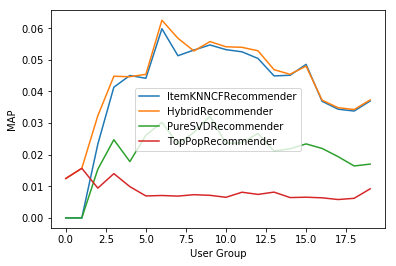

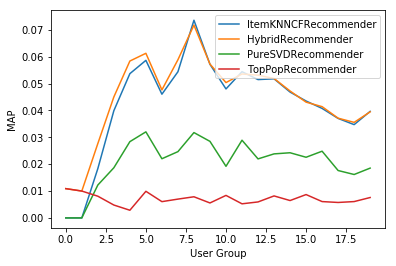

In [11]:
## TEST & VISUALIZE DIFFERENT RECSYS PERFORMANCE BASED ON N° OF INTERACTIONS HELD BY USERS
# Please, fill empty list with pretrained recommenders you want to compare

if eval:
    recommendersToCompare = [itemKNN, hybridrecommender]
    from RecLib.PerUserGroupTesting import *
    compare(URM_train, URM_test, recommendersToCompare)

In [12]:
## Predict
## SET WHICH RECOMMENDER YOU WANNA USE
final_Rec = hybridrecommender
if not eval:
    output = []
    for user_id in target_users:
        output.append((user_id, final_Rec.recommend(user_id, cutoff=10)))

In [13]:
#Writedown results
if not eval:
    with open('submission.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["user_id", "item_list"])
        for row in output:
          ranking = ''
          for val in row[1]:
            ranking = ranking + str(val) + ' '
          writer.writerow([row[0], ranking[:-1]])